In [ ]:
from __future__ import division
import random
import csv
import numpy as np
import pandas as pd
import math
from sklearn import preprocessing
from countryinfo import CountryInfo
import collections 

from matplotlib import pyplot as plt
from matplotlib import patches as patches
import pycountry
import pypopulation
import geopandas as gpd
from descartes import PolygonPatch

Summation of Province entries into single Country entries

In [ ]:
# load data
dataset = pd.read_csv('data.csv')
# Total cases country wise
dataset = dataset.groupby(['Country/Region'])[['Confirmed','Deaths', 'Recovered']].sum().reset_index()
dataset

,Country/Region,Confirmed,Deaths,Recovered
0,Afghanistan,36263,1269,25198
1,Albania,4880,144,2745
2,Algeria,27973,1163,18837
3,Andorra,907,52,803
4,Angola,950,41,242
...,...,...,...,...
182,West Bank and Gaza,10621,78,3752
183,Western Sahara,10,1,8
184,Yemen,1691,483,833
185,Zambia,4552,140,2815


In [ ]:
populations, drop = [], []

for i, country in enumerate(dataset['Country/Region']):
    try: 
        populations.append(CountryInfo(country).population())
    except:
        drop.append(i)
dataset = dataset.drop(drop)
dataset['Population'] = populations

dataset['Confirmed'] = dataset['Confirmed'] / dataset['Population']
dataset['Deaths'] = dataset['Deaths'] / dataset['Population']
dataset['Recovered'] = dataset['Recovered'] / dataset['Population']

Normalizing data to use for neural network

In [ ]:
# Extracting columns to normalize
values = dataset[['Confirmed', 'Deaths', 'Recovered']].values
# Applying Min Max Normalization
min_max_scaler = preprocessing.MinMaxScaler()
scaled = min_max_scaler.fit_transform(values)
dataset[['Confirmed', 'Deaths', 'Recovered']] = pd.DataFrame(scaled)
dataset = dataset.fillna(0)

cases = dataset[['Confirmed', 'Deaths', 'Recovered']].values
print(dataset)


          Country/Region  Confirmed    Deaths  Recovered  Population
0            Afghanistan   0.028798  0.038016   0.020669    26023100
1                Albania   0.034838  0.038765   0.020233     2895947
2                Algeria   0.014908  0.023428   0.010390    38700000
4                 Angola   0.020578  0.027102   0.016078    24383301
5    Antigua and Barbuda   0.081197  0.055890   0.036307       86295
..                   ...        ...       ...        ...         ...
181              Vietnam   0.000000  0.000000   0.000000    89708900
183       Western Sahara   0.000000  0.000000   0.000000      586000
184                Yemen   0.000000  0.000000   0.000000    25956000
185               Zambia   0.000000  0.000000   0.000000    15023315
186             Zimbabwe   0.000000  0.000000   0.000000    13061239

[169 rows x 5 columns]


In [ ]:
raw_data = np.zeros((dataset.shape[0],3))
for i in range(1, dataset.shape[0]):
    try:
        raw_data[i][0] = cases[i][0]
        raw_data[i][1] = cases[i][1]
        raw_data[i][2] = cases[i][2]
    except KeyError:
        pass

raw_data = np.delete(raw_data, 0, 0)
raw_data=raw_data.transpose()
raw_data

array([[0.034838, 0.014908, 0.020578, 0.081197, 0.257220, 0.013313,
        0.049868, 0.065947, 0.621050, 0.007932, 0.146934, 0.122495,
        0.002781, 0.003608, 0.002654, 0.146957, 0.057280, 0.007497,
        0.248398, 0.007362, 0.030296, 0.001253, 0.000760, 0.000246,
        0.067802, 0.001384, 0.404318, 0.001253, 0.111083, 0.009535,
        0.069546, 0.023626, 0.004616, 0.025525, 0.005167, 0.105728,
        0.021786, 0.048582, 0.000778, 0.031953, 0.003364, 0.000589,
        0.027946, 0.069002, 0.086956, 0.005182, 0.053036, 0.025689,
        0.005089, 0.004548, 0.059304, 0.013685, 0.023116, 0.014085,
        0.094270, 0.009263, 0.116943, 0.024190, 0.008176, 0.077930,
        0.064699, 0.084014, 0.160207, 0.083874, 0.005013, 0.003591,
        0.100820, 0.008844, 0.407878, 0.119313, 0.000000, 0.012613,
        0.019528, 0.004923, 0.005435, 0.009301, 0.047905, 0.014222,
        0.238089, 0.004739, 0.005998, 0.204400, 0.003239, 0.034833,
        0.036200, 0.005587, 0.068358, 0.134729, 

Scaling data by population

In [ ]:
def color_map(value):
    if value < 0.002:
        return([1,1,0.6])
    elif value < 0.01 and value >= 0.002:
        return([1,1,0])
    elif value < 0.06 and value >= 0.01:
        return([1,0.8,0.2])
    elif value < 0.15 and value >= 0.06:
        return([1,0.6,0.4])
    elif value < 0.5 and value >= 0.15:
        return([1,0.5,0.1])
    elif value < 0.9 and value >= 0.5:
        return([1,0.3,0.4])
    elif value < 1.2 and value >= 0.9:
        return([1,0.1,0.1])
    elif value < 1.6 and value >= 1.2:
        return([0.9,0,0])
    elif value < 1.9 and value >= 1.6:
        return([0.8,0,0])
    elif value >= 1.9:
        return([0.6,0,0.1])

In [ ]:
def find_bmu(input,network):
    minimum = float('inf')
    bmu_idx = np.array([0,0])
    # find distance between input and neurons
    for i in range(network.shape[0]):
        for j in range(network.shape[1]):
            # w = abs(network[i][j][0]- input[0]) + abs(network[i][j][1]- input[1]) + abs(network[i][j][2]- input[2])
            w = math.sqrt((network[i][j][0]-input[0])**2 + (network[i][j][1]-input[1])**2 + (network[i][j][2]-input[2])**2)
            if w < minimum:
                bmu_idx[0], bmu_idx[1] = i, j
                minimum = w
    bmu = network[bmu_idx[0], bmu_idx[1], :]
    return (bmu,bmu_idx)

Initialization for SOM

In [ ]:
#setting print format
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

dimensions = np.array([14,14]) #14 x 14 matrix
iterations = 5000
learning_rate = 0.01

#Get dimensions for raw data
m = raw_data.shape[0]
n = raw_data.shape[1]

#randomized weight vector for SOM
weight_matrix =  np.random.random((dimensions[0], dimensions[1], m))
radius = max(dimensions[0], dimensions[1])/2 
decay = iterations/np.log(radius)

SOM Algorithm

In [ ]:
lst=[]
#Learning process for SOM
for i in range(iterations):
  # select a training example at random
  rand_num = np.random.randint(1, n)
  t = raw_data[:, rand_num].reshape(np.array([m, 1]))
  
  # find Best Matching Unit
  bmu, bmu_idx = find_bmu(t,weight_matrix)

  # decay the SOM parameters
  r = radius * np.exp(-i / decay)
  l = learning_rate * np.exp(-i / iterations)

  for x in range(weight_matrix.shape[0]):
    for y in range(weight_matrix.shape[1]):
        w = weight_matrix[x, y, :].reshape(m, 1)
        # get the distance
        w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
        # checks if distance is within  radius
        if w_dist <= r**2:
            # calculate the degree of influence
            influence = np.exp(-w_dist / (2* (r**2)))
            # update the neuron's weight 
            new_w = w + (l * influence * (t - w))
            if w_dist==0:
              lsst=[]
              lsst.append(new_w.reshape(1, 3)[0])
              lsst.append(rand_num)
              lst.append(lsst)
            # update new weight to network
            weight_matrix[x, y, :] = new_w.reshape(1, 3)
        


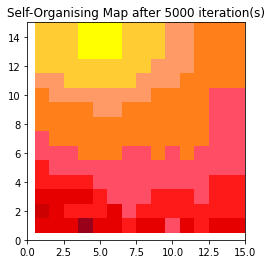

In [ ]:
def ColorMap(network, iteration):
  fig = plt.figure()
  ax = fig.add_subplot(111, aspect='equal')
  ax.set_xlim((0, network.shape[0]+1))
  ax.set_ylim((0, network.shape[1]+1))
  ax.set_title('Self-Organising Map after %d iteration(s)' % iteration)

  for x in range(1,network.shape[0]):
    for y in range(1,network.shape[1]):
        sump=network[x-1,y-1,:][0]+network[x-1,y-1,:][1]+network[x-1,y-1,:][2]
        c=color_map(sump)
        ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 200,200,
                                     facecolor=c,
                                     edgecolor='none', label="ASDQWE"))
      

  plt.show()
ColorMap(weight_matrix, iterations)

World Map

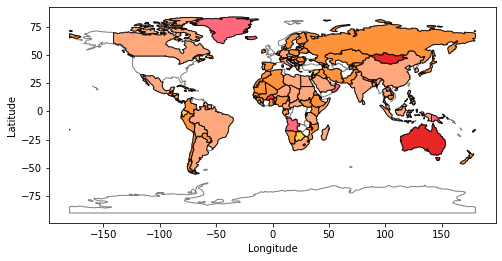

In [ ]:
''' Stack Overflow used for plotting '''

country_names = []
for line in range(len(dataset)):
    try:
      if(dataset['Country/Region'][line] not in country_names):
        country_names.append(dataset['Country/Region'][line])
    except KeyError:
          pass

def least_dist(l1,matrix):
    min_dist=1000
    for i in matrix:
        for j in i:
            sq_dist = (((j[0]-l1[0])**2) + ((j[1]-l1[1])**2) +((j[2]-l1[2])**2))
            if sq_dist < min_dist:
                min_dist = sq_dist
                selected = j
    return selected

def one_istance(array):
    one_instance=[]
    country=[]
    for x in array:
        if x[1] not in country:
            country.append(x[1])
            one_instance.append(x)
    return one_instance


o=one_istance(lst)
all_countries=[]
country_names = []
for i in o:
    best_weight=least_dist(i[0],weight_matrix)
    sump=best_weight[0]+best_weight[1]+best_weight[2]
    c=color_map(sump)
    all_countries.append([i[1],c])
    

countries_colors=[]

for k in all_countries:
  j=k[0]
  news=[]
  try:
    news.append(CountryInfo(dataset['Country/Region'][j]).iso(3))
  except KeyError:
    pass
  news.append(k[1])
  countries_colors.append(news)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax2 = world.plot(figsize=(8,8), edgecolor=u'gray', color=u"white")

for count in countries_colors:
    if (len(count)==1):
      continue
    else:
    # plot a country on the provided axes
      nami = world[world.iso_a3 == count[0]]
      namigm = nami.__geo_interface__['features']
      if namigm != []:
          namig0 = {'type': namigm[0]['geometry']['type'], \
                'coordinates': namigm[0]['geometry']['coordinates']}
          ax2.add_patch(PolygonPatch( namig0, fc=count[1], ec="black", alpha=0.85, zorder=2 ))



# the place to plot additional vector data (points, lines)
plt.ylabel('Latitude')
plt.xlabel('Longitude')

#ax2.axis('scaled')
plt.show()